# Section 6: Spectral Reduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
#Defining our own median function 
def median(arr):
    sortedArr = sorted(arr)
    if len(sortedArr) % 2 == 1:
        return sortedArr[int(len(sortedArr) / 2)]
    else:
        return (sortedArr[int(len(sortedArr) / 2)]/2 + sortedArr[int(len(sortedArr) / 2 - 1)]/2)
    
    
#MUST USE (so we don't use np.median)
def special_median(data):
    color_pixels = np.transpose([frame.flatten() for frame in data])
    medians = [median(pixel) for pixel in color_pixels] 
    master_data = np.reshape(medians, np.shape(data[0])) 
    return master_data

# Step 1: Creating a master bias and master dome flat frame

### Getting data for the blue side of the spectrograph (b fits) 

In [3]:
# getting the bias frames for the b fits files 
b_bias_arr = np.arange(101,111)
b_biasfiles = [f'data-2013-10-26-shane-public/b{i}.fits' for i in b_bias_arr]
b_biasdata = [fits.getdata(i) for i in b_biasfiles]

# # making the master bias frames by taking the median of all bias files
b_masterbias = special_median(b_biasdata) # shape (312,2112)

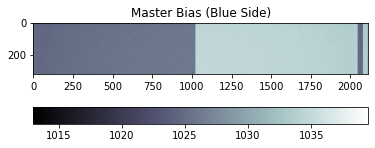

In [4]:
# showing the resulting master bias image
plt.imshow(b_masterbias, cmap='bone')
plt.title('Master Bias (Blue Side)');
plt.colorbar(orientation='horizontal')

In [5]:
# getting the dome flats 
b_dome_arr = np.arange(111,151) #This is already cleaned 
b_domefiles = [f'data-2013-10-26-shane-public/b{i}.fits' for i in b_dome_arr]
b_domedata = [fits.getdata(i) for i in b_domefiles]

# # making the masterdome based on the median of all dome flat data 
b_masterdome = special_median(b_domedata)# shape (312,2112)

# bias subtracting and normalizing the dome flat
b_norm_flat = (b_masterdome - b_masterbias) / special_median(b_masterdome - b_masterbias)

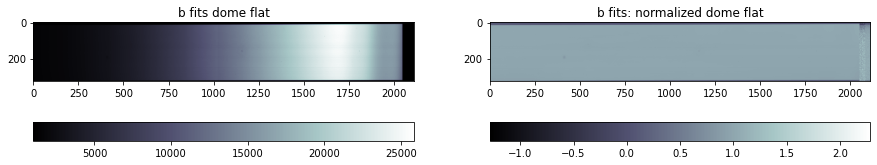

In [6]:
# good news : this basically looks the same as the individual dome flats... source trust me bro
fig, ax = plt.subplots(1,2,figsize=(15,5))

b_im1 = ax[0].imshow(b_masterdome, cmap='bone')
ax[0].set_title('b fits dome flat');
b_cbar1 = fig.colorbar(b_im1, ax=ax[0], orientation='horizontal')

b_im2 = ax[1].imshow(b_norm_flat, cmap='bone')
ax[1].set_title('b fits: normalized dome flat');
b_cbar2 = fig.colorbar(b_im2, ax=ax[1], orientation='horizontal')

# 



## Getting data for the red side of the spectrograph (r fits)

In [7]:
# getting the bias frames for the r fits files 
r_bias_arr = np.arange(102,112)
r_biasfiles = [f'data-2013-10-26-shane-public/r{i}.fits' for i in r_bias_arr]
r_biasdata = [fits.getdata(i) for i in r_biasfiles]


# making the master bias frames by taking the median of all bias files
r_masterbias = special_median(r_biasdata)  # shape (250,1232) 

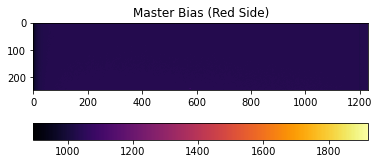

In [8]:
# showing the resulting master bias image
plt.imshow(r_masterbias, cmap='inferno')
plt.title('Master Bias (Red Side)');
plt.colorbar(orientation='horizontal')

In [9]:
#Here we check for the exposure times in order to separate the files according to their respective ones
#This is used to confirm the r_dome_arr is chosen properly
r_dome_arr_OLD = [112,113,114,115,116,117,121,122,123,126,127,128,130,131,132,137,138,139,142,143,144]
name = 'data-2013-10-26-shane-public/r{}.fits'
fnames = [name.format(i+1) for i in r_dome_arr_OLD] 
expTimes = [fits.open(i)[0].header['EXPTIME'] for i in fnames]
[print(expTimes[i], r_dome_arr_OLD[i]) for i in range(len(r_dome_arr_OLD))][0] 

5.0 112
5.0 113
3.0 114
3.0 115
3.0 116
1200.0 117
3.0 121
3.0 122
120.0 123
3.0 126
3.0 127
90.0 128
3.0 130
3.0 131
30.0 132
3.0 137
3.0 138
1.0 139
3.0 142
3.0 143
1.0 144


In [10]:
# getting the dome flats 
#separating by exposure times (used code above) 
r_dome_arr1 = [139, 144]
r_dome_arr3 = [114, 115, 116, 121, 122, 126, 127, 130, 131, 137, 138, 142, 143] 
r_dome_arr3_wSameSlit = [115, 116]
r_dome_arr5 = [112, 113]
r_dome_arr30 = [132]
r_dome_arr90 = [128]
r_dome_arr120 = [123]
r_dome_arr1200 = [117]

r_dome_arr = r_dome_arr3_wSameSlit

r_domefiles = [f'data-2013-10-26-shane-public/r{i}.fits' for i in r_dome_arr]
r_domedata = [fits.getdata(i) for i in r_domefiles]

# making the masterdome based on the median of all dome flat data 
r_masterdome = special_median(r_domedata)  # shape (250,1232) 

# bias subtracting and normalizing the dome flat
r_norm_flat = (r_masterdome - r_masterbias) / special_median(r_masterdome - r_masterbias)

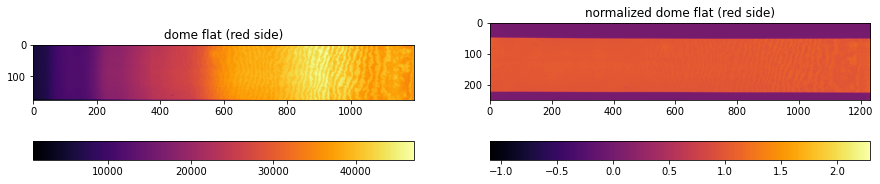

In [11]:
# plotting the dome flats 
fig, ax = plt.subplots(1,2,figsize=(15,5))

r_im1 = ax[0].imshow(r_masterdome[50:225,0:1200], cmap='inferno') #this indexing cuts out the unecessary noisy regions
ax[0].set_title('dome flat (red side)');
r_cbar1 = fig.colorbar(r_im1, ax=ax[0], orientation='horizontal')

r_im2 =ax[1].imshow(r_norm_flat, cmap='inferno')
ax[1].set_title('normalized dome flat (red side)');
r_cbar2 = fig.colorbar(r_im2, ax=ax[1], orientation='horizontal')
# notes: maybe cut out the not colored parts 

# 


# Step 2: Bias subtraction from all data 
This includes the dome flat, arclamp, and science objects. 

### Arc Lamp for Blue

In [12]:
b_arcdata = fits.getdata('data-2013-10-26-shane-public/b100.fits')
b_corrected_arc = (b_arcdata - b_masterbias) / b_norm_flat 

/tmp/ipykernel_291/1829500814.py:2: RuntimeWarning: divide by zero encountered in divide
  b_corrected_arc = (b_arcdata - b_masterbias) / b_norm_flat
/tmp/ipykernel_291/1829500814.py:2: RuntimeWarning: invalid value encountered in divide
  b_corrected_arc = (b_arcdata - b_masterbias) / b_norm_flat


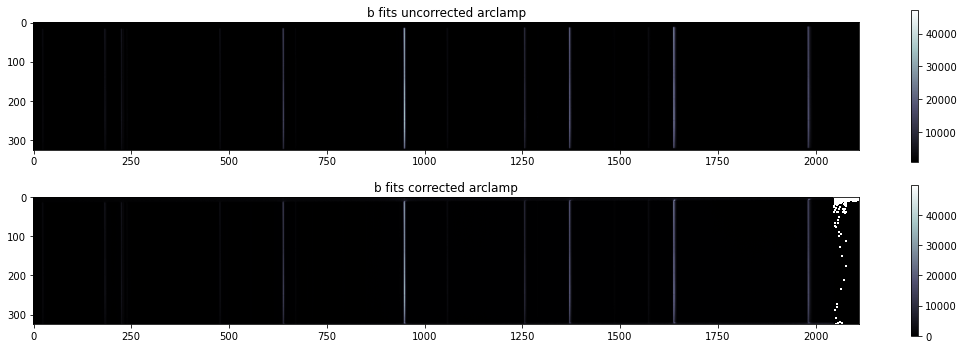

In [13]:
fig, ax = plt.subplots(2,1,figsize=(15,5))
arc_b_im1 = ax[0].imshow(b_arcdata, cmap='bone')
arc_b_im2 = ax[1].imshow(b_corrected_arc, cmap='bone')

arc_b_cbar1 = fig.colorbar(arc_b_im1, ax=ax[0], orientation='vertical')
arc_b_cbar1 = fig.colorbar(arc_b_im2, ax=ax[1], orientation='vertical')
ax[0].set_title('b fits uncorrected arclamp');
ax[1].set_title('b fits corrected arclamp');
fig.tight_layout()

# 

### Arc Lamp for Red

In [14]:
r_arc_arr = [2,3,100,101,140,145]
r_arcdata = [fits.getdata(f'data-2013-10-26-shane-public/r{i}.fits') for i in r_arc_arr]

r_corrected_arc = [(r_arcdata[i] - r_masterbias) / r_norm_flat for i in range(len(r_arcdata))] 

/tmp/ipykernel_291/2892967403.py:4: RuntimeWarning: divide by zero encountered in divide
  r_corrected_arc = [(r_arcdata[i] - r_masterbias) / r_norm_flat for i in range(len(r_arcdata))]
/tmp/ipykernel_291/2892967403.py:4: RuntimeWarning: invalid value encountered in divide
  r_corrected_arc = [(r_arcdata[i] - r_masterbias) / r_norm_flat for i in range(len(r_arcdata))]


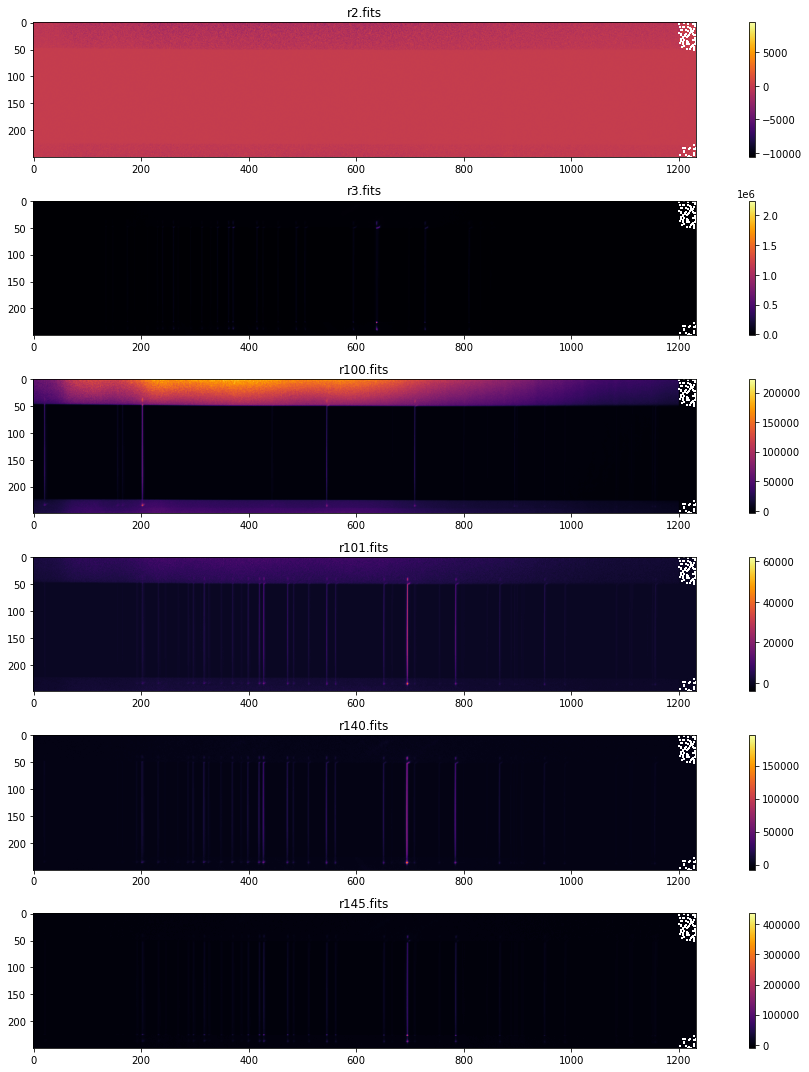

In [15]:
# plotting the bias subtracted and normalized arclamps
fig, ax = plt.subplots(6,1,figsize=(15,15))
for i in range(6):
    temp = ax[i].imshow(r_corrected_arc[i], cmap='inferno')
    ax[i].set_title(f'r{r_arc_arr[i]}.fits')
    colorbar = fig.colorbar(temp, ax=ax[i], orientation='vertical')

fig.tight_layout()

# 


## Loading in Science Objects

### Blue Science Objects

In [16]:
b_science_arr = np.arange(151,161)
b_scifile = [f'data-2013-10-26-shane-public/b{i}.fits' for i in b_science_arr]
b_sciencedata = [fits.getdata(i) for i in b_scifile]
b_sci_names = [fits.open(i)[0].header['OBJECT'] for i in b_scifile]


# subtracting the bias from the science objects 
b_corrected_science = [ (b_sciencedata[i] - b_masterbias) / b_norm_flat for i in range(len(b_sciencedata))]

/tmp/ipykernel_291/2569111297.py:8: RuntimeWarning: divide by zero encountered in divide
  b_corrected_science = [ (b_sciencedata[i] - b_masterbias) / b_norm_flat for i in range(len(b_sciencedata))]
/tmp/ipykernel_291/2569111297.py:8: RuntimeWarning: invalid value encountered in divide
  b_corrected_science = [ (b_sciencedata[i] - b_masterbias) / b_norm_flat for i in range(len(b_sciencedata))]


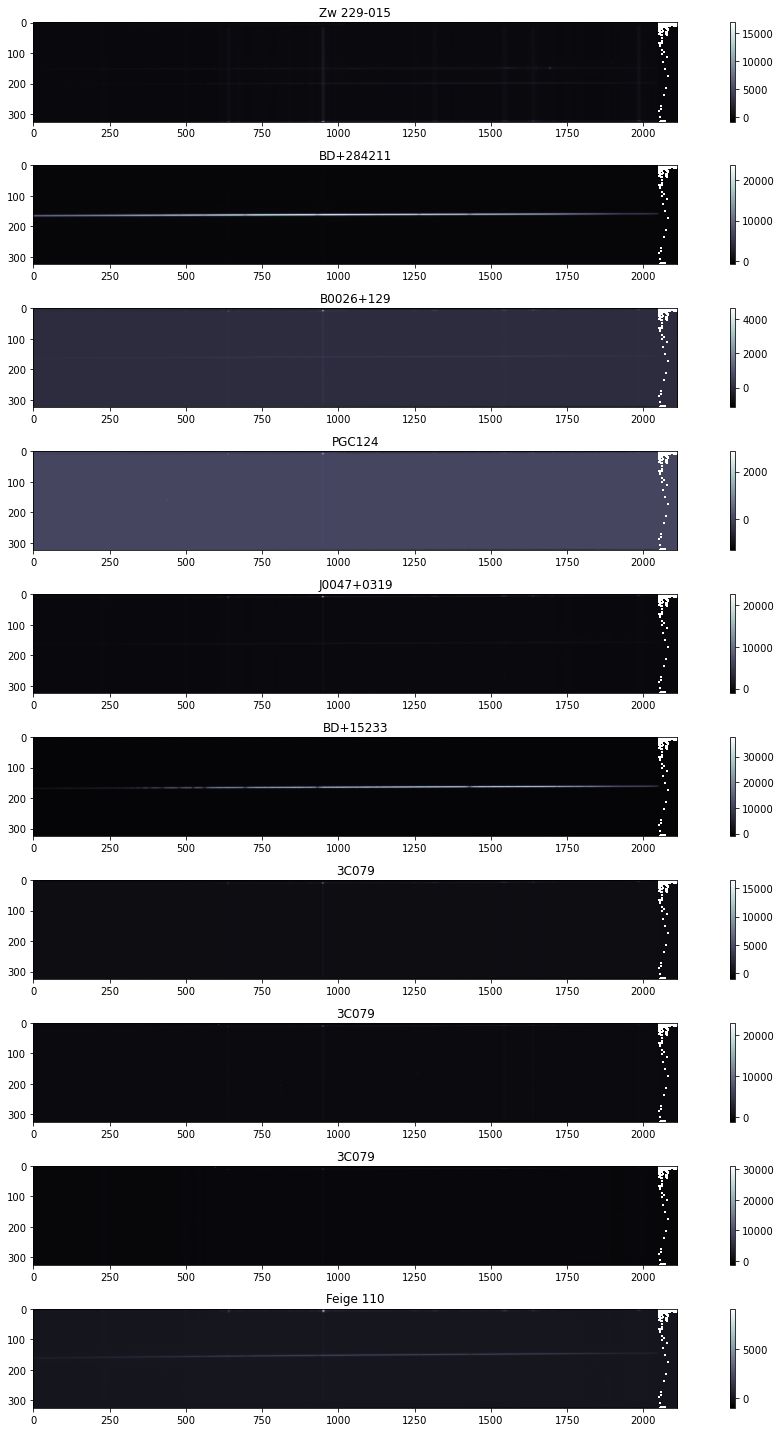

In [17]:
# plot of corrected science objects 
fig, ax = plt.subplots(10,1, figsize=(15,20))

for i in range(len(b_corrected_science)):
    temp = ax[i].imshow(b_corrected_science[i], cmap='bone')
    ax[i].set_title(b_sci_names[i])
    colorbar = fig.colorbar(temp, ax=ax[i], orientation='vertical')
    fig.tight_layout()

# 


### Red Science Objects

In [18]:
# loading in the science objects 
r_science_arr = [118,119,120,124,125,129,133,134,135,136,141]
r_scifile = [f'data-2013-10-26-shane-public/r{i}.fits' for i in r_science_arr]
r_sciencedata = [fits.getdata(i) for i in r_scifile]
r_sci_names = [fits.open(i)[0].header['OBJECT'] for i in r_scifile]

# subtracting the bias from the science objects 
r_corrected_science = [ (r_sciencedata[i] - r_masterbias) / r_norm_flat for i in range(len(r_sciencedata))]

/tmp/ipykernel_291/3292223587.py:8: RuntimeWarning: divide by zero encountered in divide
  r_corrected_science = [ (r_sciencedata[i] - r_masterbias) / r_norm_flat for i in range(len(r_sciencedata))]
/tmp/ipykernel_291/3292223587.py:8: RuntimeWarning: invalid value encountered in divide
  r_corrected_science = [ (r_sciencedata[i] - r_masterbias) / r_norm_flat for i in range(len(r_sciencedata))]


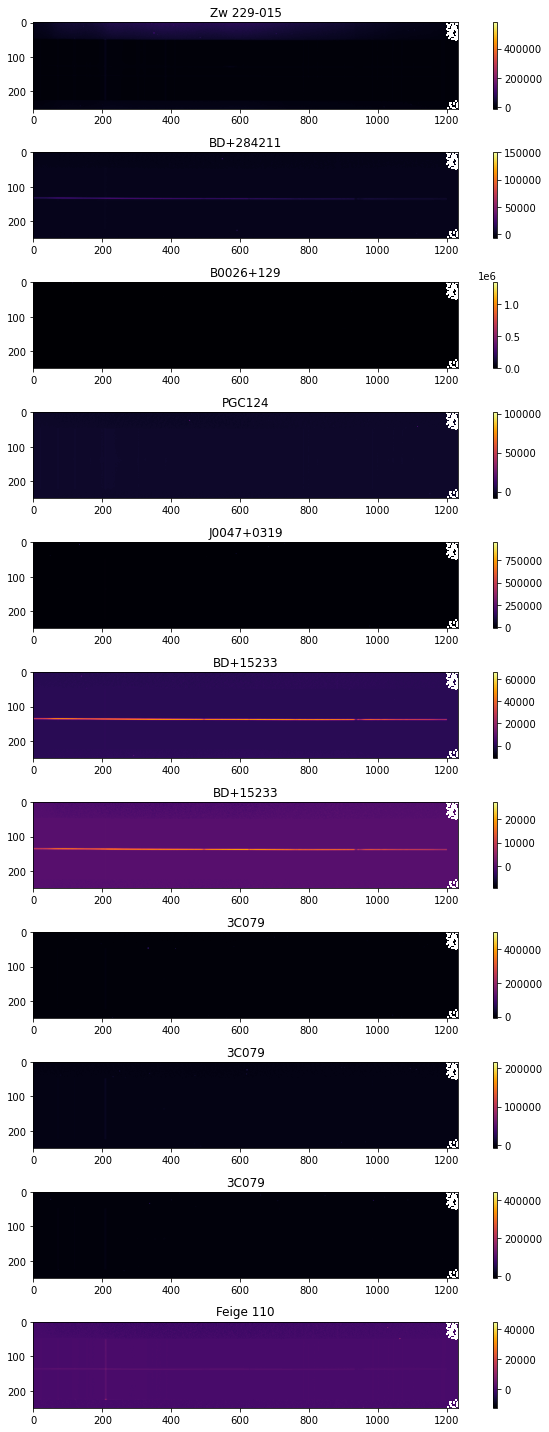

In [19]:
# plot of corrected science objects for red side
fig, ax = plt.subplots(11,1, figsize=(10,20))

for i in range(len(r_corrected_science)):
    temp = ax[i].imshow(r_corrected_science[i], cmap='inferno')
    ax[i].set_title(r_sci_names[i])
    colorbar = fig.colorbar(temp, ax=ax[i], orientation='vertical')
    fig.tight_layout()
    #plt.close()

# 


### Arc Lamp Spectra

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0, 0.5, 'Intensity')

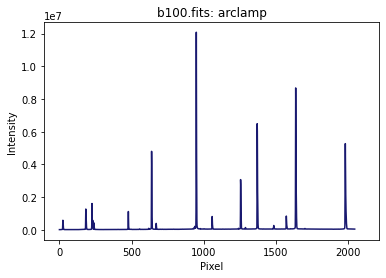

In [20]:
# plotting the arclamp spectra
# There is only one for the blue
plt.plot(np.sum(b_corrected_arc,axis=0), color='midnightblue');
plt.title('b100.fits: arclamp')
plt.xlabel('Pixel')
plt.ylabel('Intensity')

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


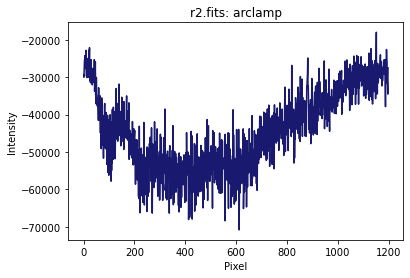

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


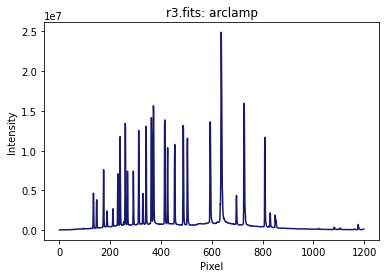

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


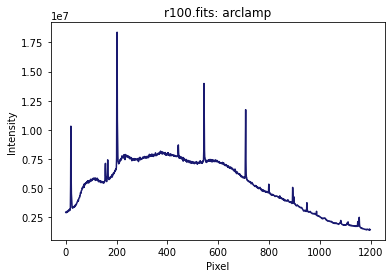

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


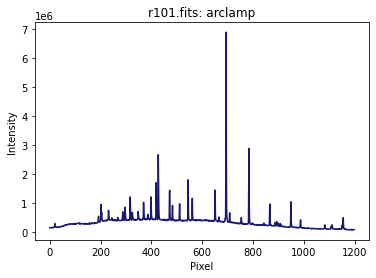

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


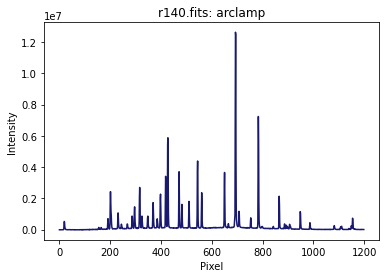

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


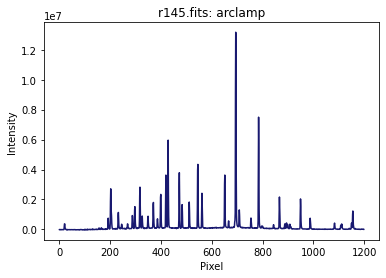

In [21]:
# plotting the arclamp spectra for red side 
# There are six for the red
for i in range(len(r_corrected_arc)):
    plt.plot(np.sum(r_corrected_arc[i],axis=0)[1:], color='midnightblue'); #Indexing from 1 so that we get rid of the initial noise
    plt.title(f'r{r_arc_arr[i]}.fits: arclamp')
    plt.xlabel('Pixel')
    plt.ylabel('Intensity')
    plt.show()


## Looking at 2 Sources

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0.5, 1.0, 'b fits: Zw 229-015')

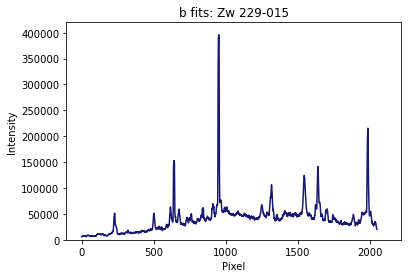

In [22]:
plt.plot(np.sum(b_corrected_science[0],axis=0), color='midnightblue');

plt.ylim(0,420000)
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.title(f'b fits: {b_sci_names[0]}')

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


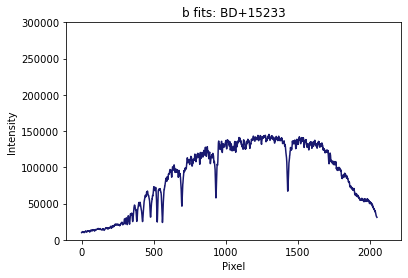

In [23]:
plt.plot(np.sum(b_corrected_science[5],axis=0), color='midnightblue');
plt.ylim(0,300000)
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.title(f'b fits: {b_sci_names[5]}');

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


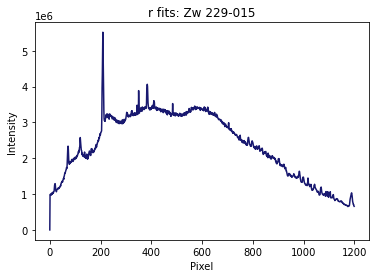

In [24]:
plt.plot(np.sum(r_corrected_science[0],axis=0), color='midnightblue');
# plt.ylim(0,7000000)
# plt.yscale('log')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.title(f'r fits: {r_sci_names[0]}');

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


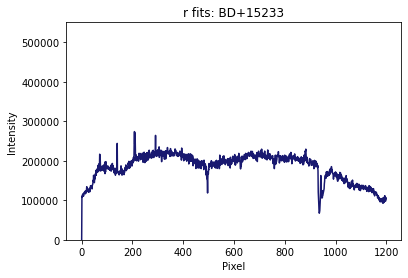

In [25]:
plt.plot(np.sum(r_corrected_science[5],axis=0), color='midnightblue');
plt.ylim(0,550000)
# plt.yscale('log')
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.title(f'r fits: {r_sci_names[5]}');

## Plotting the two Sources On Top of Each Other

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


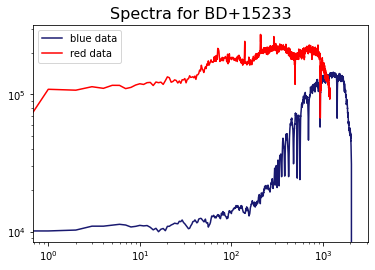

In [26]:
plt.plot(np.sum(b_corrected_science[5],axis=0), color='midnightblue', label='blue data');
plt.plot(np.sum(r_corrected_science[5],axis=0), color='red', label='red data');
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='best')
plt.title(f'Spectra for {r_sci_names[5]}', fontsize=16);

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


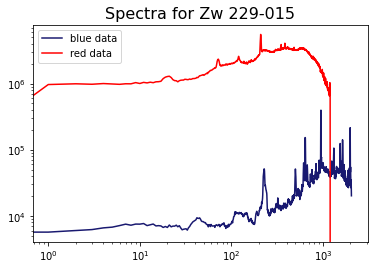

In [27]:
plt.plot(np.sum(b_corrected_science[0],axis=0), color='midnightblue', label='blue data');
plt.plot(np.sum(r_corrected_science[0],axis=0), color='red', label='red data');
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='best')
plt.title(f'Spectra for {r_sci_names[0]}', fontsize=16);